# Implementación de ResNet

En este ejercicio práctico vamos a implementar una red neuronal con conexiones residuales y vamos a probar como dichas conexiones evitan que la performance se degrade al aumentar las capas de la red neuronal.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchsummary

Para este caso, vamos a entrenar a las redes neuronales para que aproximen la función seno, por lo que vamos a generar datos utilizando dicha función. El dataset esta generado en una clase propia, que hereda de la clase base Dataset que provee PyTorch. Para crear un dataset de esta forma, es necesario implementar los metodos `__len__` y `__getitem__`. Ver [ejemplo](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

In [ ]:
class SinDataset(torch.utils.data.Dataset):
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

        self.data = np.random.normal(loc=self.mean, scale=self.stddev, size=(640, 10)).astype(np.float32)
        self.target = np.sin(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, id):
        if torch.is_tensor(id):
            id = id.tolist()

        data = self.data[id]
        target = self.target[id]

        return (data, target)

In [ ]:
train_set = SinDataset(np.pi, 1.5)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

## ResNet vs Red "plana"

Con el objetivo de probar el funcionamiento de las conexiones residuales, generamos modelos "planos", es decir, sin dichas conexiones y los entrenamos aumentando cada vez mas la cantidad de capas densas en los mismos. Luego, repetimos el proceso para modelos de iguales cantidades de capas pero agregando las conexiones residuales. Finalmente comparamos la evolución del error al final del entrenamiento, a medida que se van incrementando la cantidad de capas, para ambos casos.


In [ ]:
# Defino la cantidad de capas que quiero que tenga la red mas grande
layers_amount = 25

### Entrenamiento red "plana"

In [ ]:
class PlainModel(torch.nn.Module):
    def __init__(self, layers, input_size):
        super().__init__()
        
        self.first_layer = torch.nn.Linear(in_features=input_size, out_features=10)
        self.hidden_layers = torch.nn.ModuleList()
        for i in range(layers-1):
            self.hidden_layers.append(torch.nn.Linear(in_features=10, out_features=10))

    def forward(self, x):

        x = torch.relu(self.first_layer(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        return x

In [ ]:
plain_model = PlainModel(layers=5, input_size=10)
torchsummary.summary(plain_model, input_size=(1, 10))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]             110
            Linear-2                [-1, 1, 10]             110
            Linear-3                [-1, 1, 10]             110
            Linear-4                [-1, 1, 10]             110
            Linear-5                [-1, 1, 10]             110
Total params: 550
Trainable params: 550
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
# Funcion de entrenamiento

def train(model, data_loader, epochs):

    optimizer = torch.optim.Adam(model.parameters())
    loss = torch.nn.MSELoss()

    for epoch in range(epochs):

        epoch_loss = 0.0
        for data, target in data_loader:

            optimizer.zero_grad()
            output = model(data)
            loss_value = loss(output, target)
            epoch_loss += loss_value.item()
            loss_value.backward()
            optimizer.step()

    last_epoch_loss = epoch_loss / len(data_loader)
    print("Error de ultima epoca es {}".format(last_epoch_loss))
    return last_epoch_loss

In [ ]:
print("Entrenamiento redes neuronales planas")

plain_loss_history = []

for layers in range(1, layers_amount):

    plain_model = PlainModel(layers=layers, input_size=10)
    plain_loss = train(plain_model, train_loader, 20*layers)
    plain_loss_history.append(plain_loss)
    del plain_model

Entrenamiento redes neuronales planas
Error de ultima epoca es 0.5026911661028862
Error de ultima epoca es 0.43774456828832625
Error de ultima epoca es 0.41426376402378084
Error de ultima epoca es 0.4048270121216774
Error de ultima epoca es 0.43230809420347216
Error de ultima epoca es 0.42188720852136613
Error de ultima epoca es 0.42672154158353803
Error de ultima epoca es 0.43137332797050476
Error de ultima epoca es 0.43839105367660525
Error de ultima epoca es 0.43807089477777483
Error de ultima epoca es 0.44274013340473173
Error de ultima epoca es 0.442775858938694
Error de ultima epoca es 0.4477539211511612
Error de ultima epoca es 0.4450943574309349
Error de ultima epoca es 0.4391761288046837
Error de ultima epoca es 0.45647339820861815
Error de ultima epoca es 0.45373023152351377
Error de ultima epoca es 0.4942141830921173
Error de ultima epoca es 0.4548399180173874
Error de ultima epoca es 0.49421418458223343
Error de ultima epoca es 0.4935331165790558
Error de ultima epoca es 0.

### Entrenamiento de ResNet

In [ ]:
class ResNetBlock(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.layer1 = torch.nn.Linear(in_features, out_features)
        self.layer2 = torch.nn.Linear(in_features, out_features)

    def forward(self, x):

        shortcut = x
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        x = shortcut + x
        x = torch.relu(x)
        return x

class ResNetModel(torch.nn.Module):
    def __init__(self, layers, input_size, resnet_block):
        super().__init__()
        
        self.first_layer = torch.nn.Linear(in_features=input_size, out_features=10)
        self.hidden_layers = torch.nn.ModuleList()
        for i in range(int((layers-1)/2)):
            self.hidden_layers.append(resnet_block(in_features=10, out_features=10))

    def forward(self, x):

        x = torch.relu(self.first_layer(x))
        for layer in self.hidden_layers:
            x = layer(x)
        return x

In [ ]:
resnet_model = ResNetModel(layers=5, input_size=10, resnet_block=ResNetBlock)
torchsummary.summary(resnet_model, input_size=(1, 10))
print(resnet_model.modules)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]             110
            Linear-2                [-1, 1, 10]             110
            Linear-3                [-1, 1, 10]             110
       ResNetBlock-4                [-1, 1, 10]               0
            Linear-5                [-1, 1, 10]             110
            Linear-6                [-1, 1, 10]             110
       ResNetBlock-7                [-1, 1, 10]               0
Total params: 550
Trainable params: 550
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
<bound method Module.modules of ResNetModel(
  (first_layer): Linear(in_features=10, out_features=10, bias=True)
 

In [ ]:
print("Entrenamiento redes neuronales residuales")

resnet_loss_history = []

for layers in range(1, layers_amount):

    resnet_model = ResNetModel(layers=layers, input_size=10, resnet_block=ResNetBlock)
    resnet_loss = train(resnet_model, train_loader, 20*layers)
    resnet_loss_history.append(resnet_loss)
    del resnet_model

Entrenamiento redes neuronales residuales
Error de ultima epoca es 0.4795872554183006
Error de ultima epoca es 0.47239630818367007
Error de ultima epoca es 0.47046490758657455
Error de ultima epoca es 0.4363244339823723
Error de ultima epoca es 0.4456641122698784
Error de ultima epoca es 0.4174327626824379
Error de ultima epoca es 0.3969294264912605
Error de ultima epoca es 0.39102053791284563
Error de ultima epoca es 0.33893599510192873
Error de ultima epoca es 0.3809767246246338
Error de ultima epoca es 0.37872797399759295
Error de ultima epoca es 0.36978718638420105
Error de ultima epoca es 0.38968256711959837
Error de ultima epoca es 0.35719913691282273
Error de ultima epoca es 0.34755280911922454
Error de ultima epoca es 0.35876961797475815
Error de ultima epoca es 0.3447809636592865
Error de ultima epoca es 0.3673820674419403
Error de ultima epoca es 0.36775015145540235
Error de ultima epoca es 0.3592159882187843
Error de ultima epoca es 0.3828192040324211
Error de ultima epoca e

## Grafica con los resultados

En la siguiente grafica se puede observar como evoluciona el error de entrenamiento a medida que se incrementa la cantidad de capas dentro de la red.

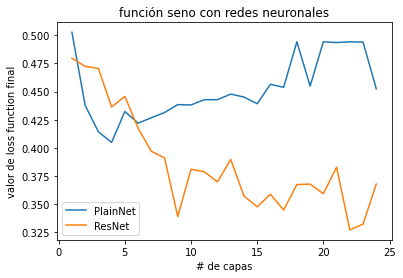

In [ ]:
plt.plot(range(1, layers_amount), plain_loss_history, label="PlainNet")
plt.plot(range(1, layers_amount), resnet_loss_history, label="ResNet")
plt.title("función seno con redes neuronales")
plt.xlabel("# de capas")
plt.ylabel("valor de loss function final")
plt.legend()
plt.show()